## MobileNet Implementation in Pytorch

This notebook contains code for a MobileNet v1 implementation in Pytorch. It was not used in the final results because it was too difficult to train. See below for a plot of the vanishing radien

### get the data

In [70]:
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch as torch
import numpy as np
import os

import matplotlib.pyplot as plt


from pathlib import Path
import pickle
import gzip
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
from PIL import Image
import glob

In [2]:
# read the data
path = "./tiny-imagenet-200/train/"
classIDs = os.listdir(path)
classIDDict = {}
for i in range(len(classIDs)):
    classIDDict[classIDs[i]] = i

imageClassCount = len(classIDs)
imagesPerClass = 500
imageCount = imageClassCount  * imagesPerClass
imageHeight = 64
imageWidth = imageHeight
channels = 3
imageSize = imageHeight * imageWidth * channels

def stackImage(image):
    return np.stack((im,)*channels, axis=-1)

In [3]:
#training data
images = np.zeros((imageCount, imageHeight, imageWidth, channels),dtype="float32")
labels = np.zeros(imageCount, dtype=int)
for i in range(len(classIDs)):
    fileNames = glob.glob(path+classIDs[i]+"/images/*.JPEG")
    for j in range(len(fileNames)):
        im = mpimg.imread(fileNames[j].replace("\\", "/"))
        if len(im.shape) < channels:
            im = stackImage(im)
        index = i * imagesPerClass + j
        images[index] = im
        labels[index] = i

In [4]:
#validation data
imageCountV = 10000
imagesV = np.zeros((imageCountV, imageHeight, imageWidth, channels),dtype="float32")
labelsV = np.zeros(imageCountV, dtype=int)
pathV = "./tiny-imagenet-200/val/"
fileNamesV = glob.glob(pathV + "images/*.JPEG")
fpV = open(pathV + "val_annotations.txt", "r")
for i in range(len(fileNamesV)):
    newlineV = fpV.readline()
    label = newlineV.split()[1]
    filePath = fileNamesV[i].replace("\\", "/")
    imNum = int(filePath.split("/")[-1][4:-5])
    im = mpimg.imread(filePath)
    if len(im.shape) < channels:
            im = stackImage(im)
    imagesV[i] = im
    labelsV[i] = classIDDict[label]

fpV.close()
    

In [5]:
x_train, y_train = images, labels
x_valid, y_valid = imagesV, labelsV

In [6]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid))

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

In [7]:
bs = 64

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )


# MobileNet Implementation

In [113]:
class dw_conv(nn.Module):
    def __init__(self, inp, out, kernel_size, stride):
        super(dw_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Sequential(
            nn.Conv2d(inp, inp, kernel_size, stride, padding=1, groups=inp),

            nn.BatchNorm2d(inp),
            nn.LeakyReLU(inplace=True)
            ),
            nn.Sequential(
            nn.Conv2d(inp, out, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out)
            )
        )
        self.depth = out

    def forward(self, x):
#         for layer in self.conv:
#             print(x.size())
        return self.conv(x)

class MobileNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.stride=1
        self.conv0 = nn.Conv2d(3, 16, kernel_size=3,stride=2,padding=1)
        self.conv1 = dw_conv(16, 32, kernel_size=3, stride=1)
        self.conv2 = dw_conv(32, 64, kernel_size=3, stride=2)
        self.conv3 =  dw_conv(64, 64, kernel_size=3, stride=1)
        self.conv4 = dw_conv(64, 128, kernel_size=3, stride=2)
        self.conv5 = dw_conv(128, 128, kernel_size=3, stride=1)
        self.conv6 = dw_conv(128, 256, kernel_size=3, stride=2)
        self.conv7 = dw_conv(256, 256, kernel_size=3, stride=1)
        self.conv8 = dw_conv(256, 256, kernel_size=3, stride=1)
        self.conv9 = dw_conv(256, 256, kernel_size=3, stride=1)
        self.conv10 = dw_conv(256, 256, kernel_size=3, stride=1)
        self.conv11 = dw_conv(256, 256, kernel_size=3, stride=1)
        self.conv12 = dw_conv(256, 200, kernel_size=3, stride=1)
        self.avgPool = nn.AvgPool2d(4)
        self.fc = nn.Linear(200, 200)
        self.avgPool = nn.AvgPool2d(4)

    def forward(self, xb):
#         print(xb.shape)
        xb = xb.view(-1, 3, 64, 64)
#         print(xb.shape)
        xb = F.leaky_relu(self.conv0(xb))
        xb = F.leaky_relu(self.conv1(xb))
        xb = F.leaky_relu(self.conv2(xb))
        xb = F.leaky_relu(self.conv3(xb))
        xb = F.leaky_relu(self.conv4(xb))
        xb = F.leaky_relu(self.conv5(xb))
        xb = F.leaky_relu(self.conv6(xb))
        xb = F.leaky_relu(self.conv7(xb))
        xb = F.leaky_relu(self.conv8(xb))
        xb = F.leaky_relu(self.conv9(xb)) 
        xb = F.leaky_relu(self.conv10(xb))
        xb = F.leaky_relu(self.conv11(xb))
        xb = F.leaky_relu(self.conv12(xb))
        xb = F.leaky_relu(self.avgPool(xb))
        xb = xb.view(-1,xb.size(1))
#         print(xb.shape)
        xb = F.leaky_relu(self.fc(xb))
#         print("fc",xb.shape)
        return xb


In [114]:

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        plot_grad_flow(model.named_parameters())
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()
                
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        counter = 0
        train_loss = 0
        for xb, yb in train_dl:
            loss = loss_batch(model, loss_func, xb, yb, opt)
            train_loss += loss[0]/loss[1]
            if counter > 20:
                break
            else:
                counter+=1
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(f"Epoch: {epoch} Training Loss: {train_loss} Valid Loss: {val_loss} Accuracy: {accuracy(model(xb), yb)}")

Epoch: 0 Training Loss: 1.8237921297550201 Valid Loss: 5.303632716369629 Accuracy: 0.03125
Epoch: 1 Training Loss: 1.8273010328412056 Valid Loss: 5.586597190856933 Accuracy: 0.0
Epoch: 2 Training Loss: 1.8246278837323189 Valid Loss: 5.384133768463135 Accuracy: 0.015625


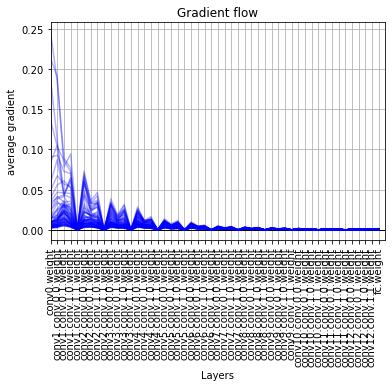

In [115]:
model = MobileNet()

lr = 0.06 # learning rate
epochs = 3  # how many epochs to train for

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

# loss_func = F.cross_entropy
def loss_func(xb, yb):
    return nn.CrossEntropyLoss()(xb,yb)

# from https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

fit(epochs, model, loss_func=loss_func, opt=opt, train_dl=train_dl, valid_dl=valid_dl)